In [1]:
import numpy as np

In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
# from cleaner_utilities import MyDataTransformer
import warnings
warnings.filterwarnings('ignore')


def relu_backward(z):
    return (z > 0).astype(int)

def tanh_backward(z):
    return 1 - z**2

def initialize_deep_layers(layers_dims):
    
    #with he -initilization but have to find out why it works better than random initialization
    
    L = len(layers_dims)
    parameters = {}
    
    for i in range(1,L):
        
        parameters[f'W{i}'] = np.random.randn(layers_dims[i], layers_dims[i-1]) * np.sqrt(1/layers_dims[i-1])
        parameters[f'b{i}'] = np.zeros((layers_dims[i],1))
        
    return parameters

def L_backward_propopgation(parameters, cache, X, Y, activation='tanh', lambd=0.0, keep_prob=1.0):
    
    #currently keeping all hidden layer prob to keep_prob
    m = X.shape[1]
    L = len(parameters) // 2
    grads = {}
    
    for i in range(L,0,-1):
        if i == L:
            #assummption last layers activation func is sigmoid
            #otherwise remove this block make changes in grad func in next block according to your choice
            grads[f'dZ{i}'] = cache[f'A{i}'] - Y
            
        else:
            grads[f'dA{i}'] = np.dot(parameters[f'W{i+1}'].T, grads[f'dZ{i+1}'] )
            
            grad_func = relu_backward if activation == 'relu' else tanh_backward
            
            grads[f'dZ{i}'] = grads[f'dA{i}'] * grad_func( cache[f'A{i}'] )
            
            #dropout implementation next two lines
            
            grads[f'dZ{i}'] = grads[f'dZ{i}'] * cache[f'dp{i}']
            
            grads[f'dZ{i}'] = grads[f'dZ{i}'] / keep_prob
            
        if i != 1 :
            grads[f'dW{i}'] = 1./m * np.dot(grads[f'dZ{i}'] ,cache[f'A{i-1}'].T) 
        else:
            grads[f'dW{i}'] = 1./m * np.dot(grads[f'dZ{i}'] ,X.T)
            
        grads[f'dW{i}'] = grads[f'dW{i}'] + (lambd/m) *(parameters[f'W{i}'])
        
        grads[f'db{i}'] = 1./m * np.sum(grads[f'dZ{i}'] ,axis=1, keepdims=True)
        
    return grads
    
    

params = initialize_deep_layers([3,4,2,1])

def sigmoid( z ) :
    return 1 / ( 1 + np.exp( -z ) )

def L_feed_forward(paramters, X, keep_prob=1.0):
    
    L = len(paramters) //2
    
    cache = {}
    
    for l in range(1,L+1):
        
        if l==1:
            cache[f'Z{l}'] = np.dot(paramters[f'W{l}'],X) + paramters[f'b{l}']
        else:
            cache[f'Z{l}'] = np.dot(paramters[f'W{l}'],cache[f'A{l-1}']) + paramters[f'b{l}']
            
        #dropout implementation dp
        if l!=L:
            cache[f'dp{l}'] = (np.random.rand(*(cache[f'Z{l}'].shape)) <= keep_prob).astype(int)
            cache[f'Z{l}'] = cache[f'Z{l}'] * cache[f'dp{l}']
            cache[f'Z{l}'] = cache[f'Z{l}'] / keep_prob
        
        
            
        if l!=L:
            cache[f'A{l}'] = np.tanh(cache[f'Z{l}'])
        else:
            cache[f'A{L}'] = sigmoid(cache[f'Z{l}'])

    return cache[f'A{L}'] , cache



def compute_cost(AL , Y ,parameters, lambd =0.0):
    
    #if lambd == 0 then it should mean that you dont want to use regularization
    
    m= Y.shape[1]
    
    eps = 1e-8
    
#     print(AL, 'cost' , Y)
    
    
    logprobs = ( Y * np.log( AL+ eps ) ) + ( ( 1 - Y ) * np.log( (1 - AL) + (eps) ) )
    cost = -1./m * np.sum(logprobs)
    cost = float(np.squeeze(cost))
    
    regularized_cost = 0
    
    L = len(parameters) // 2
    
    for i in range(1,L+1):
        
        regularized_cost += np.sum(np.square(parameters[f'W{i}']))
        
    regularized_cost = (lambd / (2*m) ) * regularized_cost
    
    return cost + regularized_cost

def update_parameters(parameters, grads, learning_rate = 0.01):
    
    L = len(parameters) // 2
    for i in range(1,L+1):
        parameters[f'W{i}'] = parameters[f'W{i}'] - learning_rate* (grads[f'dW{i}'])
        parameters[f'b{i}'] = parameters[f'b{i}'] - learning_rate* (grads[f'db{i}'])
        
    return parameters


#we are not going to use this model as this is only deep neural network ignore this

def model(X,Y,layers_dims,learning_rate=0.01, lambd=0.0, num_iterations = 200, keep_prob = 1.0, pretrained_params = None, print_cost_every_n_steps=1):

    parameters = initialize_deep_layers(layers_dims) if not pretrained_params else pretrained_params
    
    for i in range(num_iterations):
        
        AL,cache = L_feed_forward(parameters,X,keep_prob=keep_prob)

        cost = compute_cost(AL, Y, parameters,lambd=lambd)
        
        if i % print_cost_every_n_steps == 0:
            print(f'cost at iteration {i} = {cost}' )

        grads = L_backward_propopgation(parameters, cache, X, Y,lambd=lambd,keep_prob=keep_prob)

        parameters = update_parameters(parameters, grads, learning_rate)
        
    return parameters





In [3]:
def flatten(X):
    
    flattend_array = X.reshape(X.shape[0], -1)
        
    return flattend_array

In [4]:
def pad_zeros(X, pad):
    '''assuming X is of dimension (m,n_H,n_W,n_C)'''
    return np.pad(X, ((0,0),(pad,pad),(pad,pad),(0,0)), mode='constant')

In [5]:
a = np.random.rand(28,28,3)

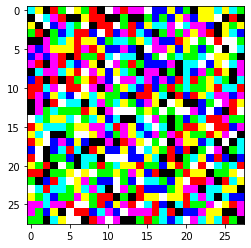

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
img = np.where(a > 0.5, 255, 0)
plt.imshow(img)

In [7]:
train = np.array([img])

In [8]:
padded_train = pad_zeros(train,2)

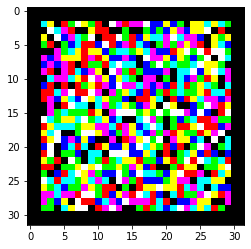

In [9]:
plt.imshow(padded_train[0])

In [10]:
def conv_single_step(a_slice_prev,kernel,b):
    
    s = a_slice_prev * kernel
    
    Z = np.sum(s)
    
    Z += float(b)
    
    return Z

In [11]:
def convolution_forward(A_prev,W,b,hparameters):
    
    m,n_H_prev,n_W_prev,n_C_prev = A_prev.shape
    
    f,f,n_C_prev,n_C = W.shape
    
    pad = hparameters['pad']
    stride = hparameters['stride']
    
    n_H = int((n_H_prev + 2*pad - f) / stride) + 1
    n_W = int((n_W_prev + 2*pad - f) / stride) + 1
    
    Z = np.zeros((m,n_H,n_W,n_C))
    
    A_prev_pad = pad_zeros(A_prev,pad)
    
    for i in range(m):
        
        a_prev = A_prev_pad[i]
        
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    
                    vert_start = h*stride
                    vert_end = vert_start + f

                    horiz_start = w*stride
                    horiz_end = horiz_start + f
                    
                    a_slice_prev = a_prev[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    kernel = W[:,:,:,c]
                    bias = b[:,:,:,c]
                    
                    Z[i,h,w,c] = conv_single_step(a_slice_prev,kernel,bias)
                    
    cache = (A_prev, W, b , hparameters)          
    
    return Z, cache
                    

    
    

In [12]:
def pool_forward(A_prev,hparameters,mode='max'):
    
    m,n_H_prev,n_W_prev,n_C = A_prev.shape
    
    pad = hparameters.get('pad',0)
    f = hparameters['f']
    stride = hparameters.get('stride',1)

    n_H = int((n_H_prev + 2*pad - f) / stride) + 1
    n_W = int((n_W_prev + 2*pad - f) / stride) + 1
    
    A = np.zeros((m,n_H,n_W,n_C))
    
    A_prev_pad = pad_zeros(A_prev,pad)
        
    for i in range(m):
        
        a_prev_pad = A_prev_pad[i]
        
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    
                    vert_start = h*stride
                    vert_end = vert_start + f

                    horiz_start = w*stride
                    horiz_end = horiz_start + f
                    
                    a_prev_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end,c]
                    
                    if mode == 'max':
                        A[i,h,w,c] = np.max(a_prev_slice)
                    else:
                        A[i,h,w,c] = np.mean(a_prev_slice)
                        
    cache = (A_prev, hparameters)
    
    return A, cache
                    

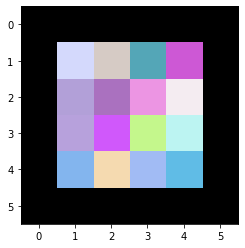

In [13]:
max_pooled, _ = pool_forward(np.array([a]),{'f': 2, 'stride' : 7, 'pad' : 5},mode='max')

plt.imshow(max_pooled[0])

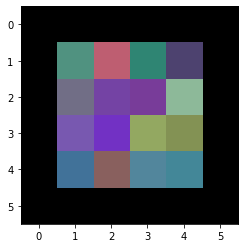

In [14]:
avg_pooled, _ = pool_forward(np.array([a]),{'f': 2, 'stride' : 7, 'pad' : 5},mode='avg')

plt.imshow(avg_pooled[0])

In [15]:
def convolution_backward(dZ,cache):
    
    A_prev, W, b, hparameters = cache
    
    m,n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    
    pad = hparameters['pad']
    stride = hparameters['stride']
    
    f,f,n_C_prev,n_C=W.shape
    
    m, n_H, n_W, n_C= dZ.shape
    
    
    dA_prev = np.zeros(A_prev.shape)
    
    A_prev_pad = pad_zeros(A_prev, pad)
    dA_prev_pad = pad_zeros(dA_prev, pad)
    
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)
    
    
    
    for i in range(m):
        
        a_prev_pad = A_prev_pad[i]
        
        for h in range(n_H):
            
            for w in range(n_W):
                
                vert_start = h * stride
                vert_end = vert_start + f
                
                horiz_start = w * stride
                horiz_end = horiz_start + f
                
                a_prev_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                
                for c in range(n_C):
                    
                    dA_prev_pad[i,vert_start:vert_end,horiz_start:horiz_end,:] +=  W[:,:,:,c] * dZ[i,h,w,c]
                    
                    dW[:,:,:,c] += a_prev_slice * dZ[i,h,w,c]
                    
                    db[:,:,:,c] += dZ[i,h,w,c]
                    
                
                
    dA_prev = dA_prev_pad[:,pad:-pad,pad:-pad,:]
    
    return dA_prev, dW, db
        
        

In [16]:
def create_max_mask_for_slice(a_slice):
    
    maximum = np.max(a_slice)
    op = np.where(a_slice==maximum , 1, 0)
    
    return op

In [17]:
def distributive_value(dZ,shape):
    n_H,n_W = shape
    avg = dZ / (n_H * n_W)
    return np.ones(shape) * avg

In [18]:

def pool_backward(dA,cache,mode='max'):
    
    
    m,n_H,n_W,n_C = dA.shape
    
    
    A_prev, hparameters = cache
    
    pad = hparameters.get('pad',0)
    stride = hparameters['stride']
    f = hparameters['f']
    
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    
    A_prev_pad = pad_zeros(A_prev, pad)
    
    dA_prev = np.zeros(A_prev.shape)
    

    
    for i in range(m):
        
        for h in range(n_H):
            
            for w in range(n_W):
                
                vert_start = h*stride
                vert_end = vert_start + f
                
                horiz_start = w*stride
                horiz_end = horiz_start + f
                
                for c in range(n_C):

                    a_prev_slice = A_prev_pad[i,vert_start:vert_end, horiz_start:horiz_end,c]
                    
                    if mode == 'max':
#                         if i == 0 and c == 0 and h == 0 and w == 0 : print(a_prev_slice.shape,'check1')
                        mask = create_max_mask_for_slice(a_prev_slice)
                        dA_prev[i,vert_start:vert_end, horiz_start:horiz_end,c] += mask * dA[i,h,w,c]
                    else:
                        da = dA[i,h,w,c]
                        
                        shape = (f, f)
                        
                        dist_matrx = distributive_value(da,shape)
                    
                        dA_prev[i,vert_start:vert_end, horiz_start:horiz_end, c] += dist_matrx
                        
                        
    return dA_prev
    

In [19]:
def cnn_model(X,Y,nn_layers_dims,learning_rate=0.01, lambd=0.0, num_iterations = 200, keep_prob = 1.0, 
              pretrained_params = None, print_cost_every_n_steps=1):
    
    '''X : shape(m,n_H,n_W,n_C)'''
    hparameter = {}
    
    print('Initializing CNNs kernel and biases')
    
    kernel1 = np.random.rand(3,3,1,8) 
    kernel2 = np.random.rand(3,3,8,8) 
    
    
    bias1 = np.zeros((1,1,1,8))
    bias2 = np.zeros((1,1,1,8))
    
#     parameters = initialize_deep_layers(layers_dims)
    
    for i in range(num_iterations):
        
        hparameter['pad'] = 1
        hparameter['stride'] = 1

        caches = {}

        #convolve
        conv1, cache = convolution_forward(X,kernel1,bias1,hparameter)

        caches['kernel1'] = cache

        #activation
        A1 = np.where(conv1>0,conv1,0)

        #pool
        hparameter = {'f' : 2, 'stride' : 1}
        P1,cache = pool_forward(A1,hparameter)
        
        caches['pool1'] = cache

        hparameter['pad'] = 1
        hparameter['stride']= 1

        conv2,cache = convolution_forward(P1,kernel2,bias2,hparameter)
        caches['kernel2'] = cache

        A2 = np.where(conv2 > 0 , conv2 , 0) #relu

        hparameter = {'f' : 2, 'stride' : 1}
        P2,cache = pool_forward(A2,hparameter,mode='avg')

        p2_shape = P2.shape

        caches['pool2'] = cache
        

        P2 = flatten(P2)

        flattend_X = P2.T

        if i == 0:
            
            print('Initializing neural network deep layers')
            print('\n')
            print('-' * 20 , '-' , '-' *20) 
            print('Cost Decription' , ' '*4 , '|' , 'Cost')
            print('-' * 20 , '|' , '-' *20) 
            
            parameters = initialize_deep_layers( [flattend_X.shape[0]] + nn_layers_dims)


        AL,cache = L_feed_forward(parameters,flattend_X,keep_prob=keep_prob)

        cost = compute_cost(AL,Y,parameters,lambd=0)
        
        print(f'cost for iteration {i} | {cost}')

        grads = L_backward_propopgation(parameters, cache, flattend_X, Y,lambd=lambd,keep_prob=keep_prob)

        dZ1 = grads['dZ1'] 

        dflattend_X = np.dot(parameters['W1'].T , dZ1)

        dflattend_X = dflattend_X.T 

        dP2 = dflattend_X.reshape(p2_shape) #dA for conv2

        dP2_prev = pool_backward(dP2,caches['pool2'],mode='avg')
        
        dZconv2 = dP2_prev * relu_backward(conv2) # f'(z) for relu
        
        dP1,dkernel2,db2 = convolution_backward(dZconv2, caches['kernel2'])

        dP1_prev = pool_backward(dP2,caches['pool1'])

        dZconv1 = dP1_prev * relu_backward(conv1) # f'(z) for relu
        
        
        print('-' * 20, '|' , '-'*20)        

        dP0,dkernel1,db1 = convolution_backward(dZconv1, caches['kernel1'])


        parameters = update_parameters(parameters, grads, learning_rate)
        
        kernel1 = kernel1 - learning_rate * dkernel1
        kernel2 = kernel2 - learning_rate * dkernel2
        
        bias1 = bias1 - learning_rate * db1
        bias2 = bias2 - learning_rate * db2
        
    cnn_parameters = {'kernel1' :kernel1 , 'kernel2' : kernel2 , 'bias1' : bias1 , 'bias2' : bias2}
    
    return parameters,cnn_parameters
    

In [20]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')

train_data = mnist['data']

train_data = train_data.reshape(70000,28,28,1)


sample_train = train_data[:50]

y = mnist['target']

y = (y.astype(int) > 5).astype(int)

y = y.reshape(1,-1)

y = y[:,:50]

sample_train.shape

(50, 28, 28, 1)

In [21]:
y

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 0]])

In [22]:

conv_op = cnn_model(sample_train,y,nn_layers_dims = [256,1],num_iterations=40)


Initializing CNNs kernel and biases
Initializing neural network deep layers


-------------------- - --------------------
Cost Decription      | Cost
-------------------- | --------------------
cost for iteration 0 | 0.8666711101879426
-------------------- | --------------------
cost for iteration 1 | 0.7584191996056615
-------------------- | --------------------
cost for iteration 2 | 0.7011629345744997
-------------------- | --------------------
cost for iteration 3 | 0.6707877094268825
-------------------- | --------------------
cost for iteration 4 | 0.6529025786651619
-------------------- | --------------------
cost for iteration 5 | 0.6406840716561668
-------------------- | --------------------
cost for iteration 6 | 0.6310790380641679
-------------------- | --------------------
cost for iteration 7 | 0.6227380438834661
-------------------- | --------------------
cost for iteration 8 | 0.6150614611629899
-------------------- | --------------------
cost for iteration 9 | 0.6077793

In [24]:
kernel1 = np.ones((3,3,1,2))

vert_filter = kernel1[:,:,0,0]* np.array([[ -1 , 0 ,1, ] ] * 3)

kernel1[:,:,0,0] *= vert_filter

kernel1[:,:,0,1] *= vert_filter.T # effectively a horizontal edge filter



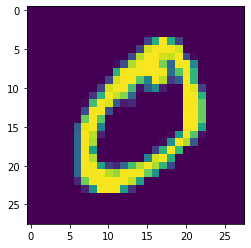

In [51]:
plt.imshow(sample_train[1].reshape(28,28))

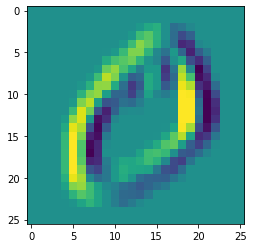

In [40]:
convd = convolution_forward(sample_train,kernel1, np.zeros((1,1,1,2)) , {'stride' : 1 , 'pad' : 0})

convd[0].shape

convd1 = convd[0][1][:,:,1]
convd2 = convd[0][1][:,:,0]

plt.imshow(convd2)

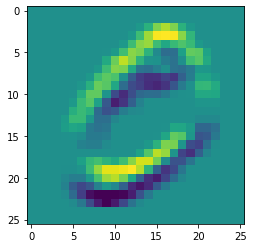

In [41]:
plt.imshow(convd1)

In [36]:
nn_params , cnn_params = conv_op

In [38]:
cnn_params

{'kernel1': array([[[[0.99792679, 0.04777589, 0.27061178, 0.9238762 , 0.17923507,
           0.62584118, 0.42747638, 0.82210957]],
 
         [[0.63135111, 0.76836416, 0.76229989, 0.22676766, 0.19414043,
           0.58534674, 0.68877259, 0.75614895]],
 
         [[0.36566172, 0.82440536, 0.53547204, 0.60593527, 0.41206315,
           0.98778796, 0.2187841 , 0.22594565]]],
 
 
        [[[0.96516548, 0.19171193, 0.10727372, 0.64336345, 0.51996433,
           0.75608701, 0.91177286, 0.67631139]],
 
         [[0.72587609, 0.46240582, 0.84949149, 0.69899621, 0.96487068,
           0.88402835, 0.50916711, 0.90246562]],
 
         [[0.92067378, 0.62185961, 0.4495927 , 0.22534536, 0.71719878,
           0.77051306, 0.61457074, 0.45278759]]],
 
 
        [[[0.72519819, 0.23812972, 0.96340736, 0.9277503 , 0.16052246,
           0.12296714, 0.89698391, 0.50325695]],
 
         [[0.92519646, 0.08599527, 0.31589057, 0.07058611, 0.70933915,
           0.48408849, 0.68636785, 0.45982381]],
 
       

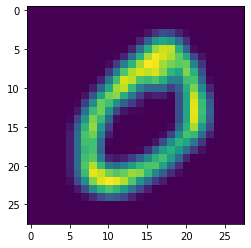

In [45]:
convd = convolution_forward(sample_train,cnn_params['kernel1'], cnn_params['bias1'] , {'stride' : 1 , 'pad' : 1})

convd[0].shape

convd1 = convd[0][1][:,:,1]
convd2 = convd[0][1][:,:,0]
convd3 = convd[0][1][:,:,2]
convd4 = convd[0][1][:,:,3]

plt.imshow(convd2)

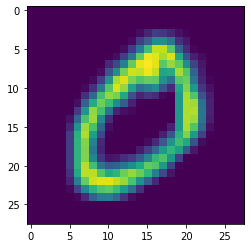

In [46]:
plt.imshow(convd1)

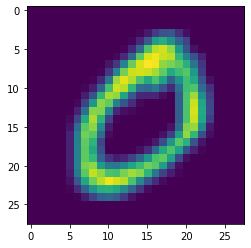

In [47]:
plt.imshow(convd3)

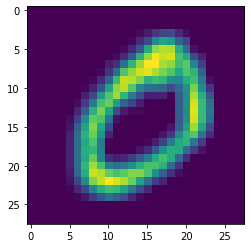

In [48]:
plt.imshow(convd4)